In this approach, we begin with an initially imbalanced dataset and use sampling methods, such as undersampling and oversampling, to balance it. After achieving a balanced dataset, we proceed with exploratory data analysis (EDA) and model building.

In [1]:
import pandas as pd
from sklearn.utils import shuffle
import string

In [2]:
fake = pd.read_csv("data/Fake - Imbalanced.csv")
true = pd.read_csv("data/True.csv")

In [3]:
# Adding labels to the data
fake['target'] = 'fake'
true['target'] = 'true'

In [4]:
fake.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [5]:
# Concatenating the dataframes
data = pd.concat([fake, true]).reset_index(drop = True)

data = shuffle(data)
data = data.reset_index(drop=True)
data.head()

,title,text,subject,date,target
0,Trump taps RNC's Spicer for White House spokesman,WASHINGTON (Reuters) - The Republican National...,politicsNews,"December 22, 2016",true
1,U.S. to unveil revised self-driving car guidel...,WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,"September 5, 2017",true
2,Grand jury issues subpoenas in connection with...,WASHINGTON (Reuters) - A grand jury has issued...,politicsNews,"August 3, 2017",true
3,"Trump and Irish PM talk migration, Brexit in p...",(Reuters) - Irish Prime Minister Leo Varadkar ...,politicsNews,"June 27, 2017",true
4,Brazil police arrest ex-minister Vieira Lima a...,BRASILIA (Reuters) - Brazilian police on Frida...,worldnews,"September 8, 2017",true


Handling Imbalance and Dataset Preparation:

In [6]:
target_distribution = data['target'].value_counts()
print(target_distribution)

true    21417
fake     2434
Name: target, dtype: int64


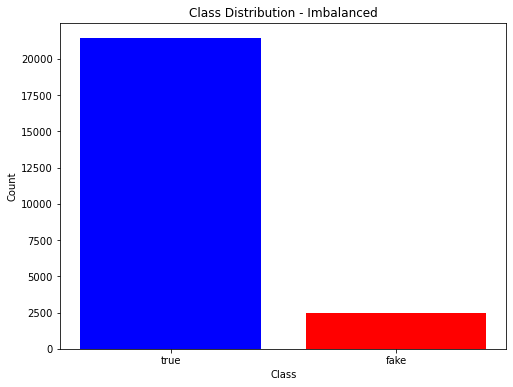

In [16]:
import matplotlib.pyplot as plt

class_counts = data['target'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution - Imbalanced')
plt.show()

The distribution is imbalanced because the number of instances labeled as true vastly exceeds the number of instances labeled as fake. Specifically, the dataset contains 21,417 instances of true news compared to only 2,434 instances of fake news. This significant disparity indicates that the true class is much more prevalent than the fake class. In machine learning, such an imbalance can lead to a model that is biased towards the more frequent class (true news), potentially resulting in poor performance in identifying and correctly classifying instances of the less frequent class (fake news). 

In [7]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)

# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)

# Convert to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

# Remove punctuation
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

data.head()

,text,subject,target
0,washington reuters the republican national co...,politicsNews,true
1,washington reuters president donald trump’s a...,politicsNews,true
2,washington reuters a grand jury has issued su...,politicsNews,true
3,reuters irish prime minister leo varadkar hel...,politicsNews,true
4,brasilia reuters brazilian police on friday s...,worldnews,true


In [8]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\neil1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We can balance the dataset using either undersampling or oversampling.

However, in the context of our fake news detection problem, where true news significantly outweighs fake news, undersampling seems the more suitable approach. Given our goal of accurately identifying fake news, it's essential to address the imbalance to prevent the model from being biased towards the majority class. Undersampling allows us to reduce the number of instances in the majority class (true news) while retaining the original instances of the minority class (fake news). This focused approach ensures that the model learns the distinguishing features of fake news more effectively, leading to improved detection accuracy.

Ultimately, undersampling aligns with our objective of building a robust fake news detection model that can effectively identify and classify instances of fake news amidst a predominance of true news articles.

In [9]:
X = data.drop('target', axis=1)
y = data['target']

print("Before Undersampling, counts of label 'true' in the dataset: {}".format(sum(y == 'true')))
print("Before Undersampling, counts of label 'fake' in the dataset : {} \n".format(sum(y == 'fake')))

from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import NearMiss

vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X['text'])

nm = NearMiss(version=1)

X_nm, y_nm = nm.fit_resample(X_vectorized, y)

print("After Undersampling, counts of label 'true' in the dataset: {}".format(sum(y_nm == 'true')))
print("After Undersampling, counts of label 'fake' in the dataset : {} \n".format(sum(y_nm == 'fake')))

Before Undersampling, counts of label 'true' in the dataset: 21417
Before Undersampling, counts of label 'fake' in the dataset : 2434 

After Undersampling, counts of label 'true' in the dataset: 2434
After Undersampling, counts of label 'fake' in the dataset : 2434 



Now using undersampling (nearmiss algorithm), the classes are balanced and we can now perform modeling.

NearMiss Algorithm:

The NearMiss algorithm works in three steps:

a) Selection Criterion: NearMiss uses a distance-based criterion to select which samples from the majority class to keep. There are different versions of NearMiss, each with its own selection criterion. For example, version 1 selects samples from the majority class that are nearest to the minority class samples, while version 2 selects samples that are farthest from the decision boundary, and version 3 combines both strategies.

b) Nearest Neighbors: After selecting the criterion, NearMiss computes the distances between each sample from the majority class and the minority class samples using a chosen distance metric (e.g., Euclidean distance). It then selects a subset of majority class samples based on the chosen criterion.

c) Undersampling: Finally, NearMiss removes the selected majority class samples, resulting in a balanced dataset where the ratio between the minority and majority class is reduced. This balanced dataset can then be used for training machine learning models.

In [15]:
X_nm_inverse = vectorizer.inverse_transform(X_nm)

X_nm_strings = [" ".join(words) for words in X_nm_inverse]

X_nm_df = pd.DataFrame({'text': X_nm_strings})

balanced_dataset = pd.concat([X_nm_df, pd.DataFrame({'target': y_nm})], axis=1)
balanced_dataset.head()

,text,target
0,republican trump republicans public president ...,fake
1,national committee donald trump house announce...,fake
2,donald trump white new would think expected im...,fake
3,national donald trump next team freedom respon...,fake
4,republican national trump press white house an...,fake


BASIC DATA EXPLORATION:

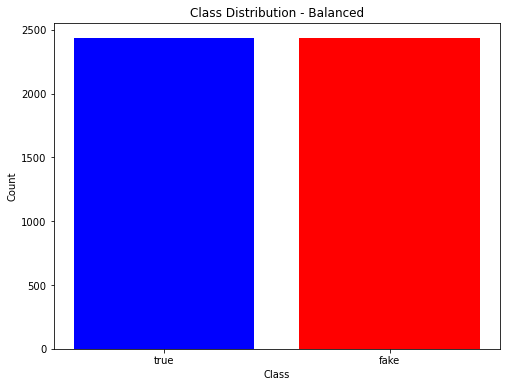

In [17]:
class_counts = balanced_dataset['target'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution - Balanced')
plt.show()

MODELLING: